In [1]:
import glob
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# original_image内のファイルのパスををすべて取得する。
files = glob.glob('original_image/*.jpg')

# imgs内に元のデータを入れる
# file path => Python Imaging Library => ndarray
imgs = np.array([img_to_array(load_img(f, target_size=(544, 384))) for f in files])

# imgs内にいくつファイルが入っているか
imgs.shape

(300, 544, 384, 3)

In [2]:
import os

th = 128

lavel_files = glob.glob('lavel_image/*.png')

# labels内にラベルデータを入れる
# file path => Python Imaging Library => ndarray
labels = np.array([img_to_array(load_img(f, target_size=(544, 384))) for f in lavel_files])

for file in labels:
    file[file < th] = 0
    file[file >= th] = 255

labels.shape

(300, 544, 384, 3)

In [3]:
from keras.models import Model
from keras.layers import Input, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPool2D
from tensorflow.keras.layers import BatchNormalization

input = Input(shape = imgs.shape[1:])

x = input

x = BatchNormalization()(x)

# Encoder

x = Conv2D(16, 3, padding='same', activation = 'relu')(x)
x = MaxPool2D()(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(32, 3, padding='same', activation = 'relu')(x)
x = Conv2D(32, 3, padding='same', activation = 'relu')(x)
x = Conv2D(32, 3, padding='same', activation = 'relu')(x)
x = MaxPool2D()(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(64, 3, padding='same', activation = 'relu')(x)
x = Conv2D(64, 3, padding='same', activation = 'relu')(x)
x = Conv2D(64, 3, padding='same', activation = 'relu')(x)
x = MaxPool2D()(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(128, 3, padding='same', activation = 'relu')(x)
x = Conv2D(128, 3, padding='same', activation = 'relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Decoder

x = Conv2DTranspose(64, 3, strides = 2, padding='same', activation = 'relu')(x)
x = Conv2D(64, 3, padding='same', activation = 'relu')(x)
x = Conv2D(64, 3, padding='same', activation = 'relu')(x)
x = Conv2D(64, 3, padding='same', activation = 'relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2DTranspose(32, 3, strides = 2, padding='same', activation = 'relu')(x)
x = Conv2D(32, 3, padding='same', activation = 'relu')(x)
x = Conv2D(32, 3, padding='same', activation = 'relu')(x)
x = Conv2D(32, 3, padding='same', activation = 'relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2DTranspose(16, 3, strides = 2, padding='same', activation = 'relu')(x)
x = Conv2D(16, 3, padding='same', activation = 'relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Conv2D(1, 1, activation = 'sigmoid')(x)

model = Model(inputs = input, outputs = output)

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 544, 384, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 544, 384, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 544, 384, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 272, 192, 16)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 272, 192, 16)     64        
 hNormalization)                                                 
                                                             

In [6]:
hist = model.fit(imgs, labels, initial_epoch = 440, epochs = 445, batch_size = 1)

Epoch 441/445
300/300 [==============================] - 200s 667ms/step - loss: 394.6595 - mae: 2.5365
Epoch 442/445
300/300 [==============================] - 207s 689ms/step - loss: 394.6574 - mae: 2.5385
Epoch 443/445
300/300 [==============================] - 213s 710ms/step - loss: 394.6557 - mae: 2.5400
Epoch 444/445
300/300 [==============================] - 237s 789ms/step - loss: 394.6548 - mae: 2.5409
Epoch 445/445
300/300 [==============================] - 218s 728ms/step - loss: 394.6544 - mae: 2.5415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


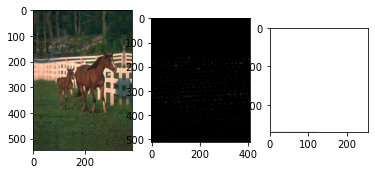

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def predict(index, s = 6.0):
    plt.rcParams['figure.figsize'] = (s, s)

    sh = imgs.shape[1:-1]

    # 輪郭の検出（予測処理）
    pred = model.predict(np.array([imgs[index]]))[0]
    pred *= 255

    plt.subplot(1, 3, 1)
    # 入力画像の表示
    plt.imshow(imgs[index].astype(int))

    plt.subplot(1, 3, 2)
    # 輪郭画像（ラベルデータ）の表示
    plt.imshow(labels[index].reshape((512, 408, 3)), cmap = 'gray')

    plt.subplot(1, 3, 3)
    # predict の結果表示
    plt.imshow(pred.reshape((272, 256, 3)), cmap = 'gray')

predict(0)